In [13]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from SwarmPackagePy import wsa
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

## Data Upload

In [3]:
train_path = 'trafficnet_dataset_v1/train'
test_path = 'trafficnet_dataset_v1/test'

In [4]:
class_names = ['accident', 'dense_traffic', 'fire', 'sparse_traffic']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

no_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [5]:
def load_data(dataset):
    images = []
    labels = []

    if os.path.exists(dataset) and os.path.isdir(dataset): 
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            # itteration through immages in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                if isinstance(image, np.ndarray):
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE) 
                        
                    #append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
            print(len(images))
        images = np.array(images, dtype = 'int32')
        labels = np.array(labels, dtype = 'int32')
        return (images, labels)
    else: return print("Folder does not exist")

In [6]:
(training_img, training_labels) = load_data(train_path)
(test_img, test_labels) = load_data(test_path)

100%|██████████| 900/900 [00:08<00:00, 107.52it/s]


900


100%|██████████| 900/900 [00:08<00:00, 107.56it/s]


1800


100%|██████████| 900/900 [00:08<00:00, 100.85it/s]


2700


100%|██████████| 901/901 [00:08<00:00, 105.26it/s]


3600


100%|██████████| 200/200 [00:01<00:00, 101.83it/s]


200


100%|██████████| 200/200 [00:01<00:00, 104.17it/s]


400


100%|██████████| 200/200 [00:01<00:00, 107.20it/s]


600


100%|██████████| 200/200 [00:01<00:00, 106.49it/s]

800


Shuffling the data and creating even batches

In [7]:
from sklearn.utils import shuffle

training_img = training_img / 255.0 
test_img = test_img / 255.0

training_img_shuffle, training_labels_shuffle = shuffle(training_img, training_labels, random_state=21)

In [8]:
import random
def create_sample(dataset, labels, batch_size):  # equal sizes of classes
    size = batch_size // no_classes
    random_indexes = []
    for i in range(no_classes):
        random_indexes.append(random.sample(range(i*900, (i+1)*900), size))
    random_indexes = shuffle(np.array(random_indexes).flatten(), random_state=21)
    batch_images = []
    batch_labels = []
    for i in random_indexes:
        batch_images.append(dataset[i])
        batch_labels.append(labels[i])
    return np.array(batch_images), np.array(batch_labels)

## Setting up VGG models and model creator

In [53]:
from keras.applications.vgg16 import VGG16

model16 = VGG16(weights='imagenet', include_top=False)

In [67]:
model16.layers[1:20]

In [54]:
train_feat_vg = model16.predict(training_img_shuffle)
print(train_feat_vg.shape)

113/113 [==============================] - 130s 1s/step
(3600, 4, 4, 512)


In [55]:
from keras.applications.vgg19 import VGG19

model19 = VGG19(weights='imagenet', include_top=False)

In [56]:
model19.layers

In [57]:
def create_model(version, dense_size, filters):
    if version == 16:
        bottom_model = model16
        cap = 20
    elif version == 19:
        bottom_model = model19
        cap = 23

    model1 = Sequential()
    model1.add(InputLayer(input_shape=(150, 150, 3)))
    for layer in bottom_model.layers[1:cap]:
        model1.add(layer)
    for layer in model1.layers:
        layer.trainable = False
    model1.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
    model1.add(Flatten(input_shape=(4, 4, 512)))
    model1.add(Dense(dense_size, activation='relu'))
    model1.add(Dense(4, activation='softmax'))

    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model1

### Top layer optimization by Whale Swarm Algorithm

In [17]:
filters = [8,16,32,64,128, 256, 512, 1024]
dense_sizes = [8, 16, 32, 64, 96, 128, 196, 256]

In [88]:
history = []

In [89]:
def fitness_check(x):
    print(f"check {x}")
    filter = filters[round(x[0]-0.5)]
    dense_size = dense_sizes[round(x[1]-0.5)]
    if round(x[2]/2) >= 4.0:
        version = 19
    else:
        version = 16

    model = create_model(version, dense_size, filter)


    data_img, data_labels = create_sample(training_img, training_labels, 800)

    network = model.fit(data_img, data_labels, epochs=5, validation_split = 0.2)

    #test_loss, test_acc = model.evaluate(test_img, test_labels)

    history.append([version, filter, dense_size, network.history['accuracy'], network.history['val_accuracy'], network.history['loss'], network.history['val_loss']])
    print(network.history['accuracy'][-1])
    print(network.history['val_accuracy'][-1])

    return 1-network.history['val_accuracy'][-1]

In [91]:
w = wsa(10, fitness_check, 0, 8, dimension=3, iteration=30, ro0=0.005, eta=3.0)
best = w.get_Gbest()
best_accuracy = fitness_check(np.array(best))

print(f'Best accuracy: {best_accuracy} for {best}')

check [3.16444715 2.11652011 5.31615595]
Epoch 1/5
20/20 [==============================] - 26s 1s/step - loss: 0.9661 - accuracy: 0.6156 - val_loss: 0.6799 - val_accuracy: 0.7625
Epoch 2/5
20/20 [==============================] - 23s 1s/step - loss: 0.4540 - accuracy: 0.8281 - val_loss: 0.4915 - val_accuracy: 0.8313
Epoch 3/5
20/20 [==============================] - 23s 1s/step - loss: 0.2095 - accuracy: 0.9359 - val_loss: 0.5276 - val_accuracy: 0.8188
Epoch 4/5
20/20 [==============================] - 23s 1s/step - loss: 0.1164 - accuracy: 0.9781 - val_loss: 0.4527 - val_accuracy: 0.8188
Epoch 5/5
20/20 [==============================] - 23s 1s/step - loss: 0.0584 - accuracy: 0.9922 - val_loss: 0.4816 - val_accuracy: 0.8062
0.9921875
0.8062499761581421
check [2.15969728 0.42463963 6.71201106]
Epoch 1/5
20/20 [==============================] - 24s 1s/step - loss: 1.3608 - accuracy: 0.3172 - val_loss: 1.3320 - val_accuracy: 0.3375
Epoch 2/5
20/20 [==============================] - 23s 

KeyboardInterrupt: 

In [107]:
results = []
best_val = 0
best_train = 0
best_data = []
for i in history:
    if i[4][-1] > best_val:
        best_val = i[4][-1]
        best_train = i[3][-1]
        best_data = [i[0], i[1], i[2]]
    results.append([i[0], i[1], i[2], i[3][-1], i[4][-1], i[5][-1], i[6][-1]])

print(f'Best accuracy: {best_val}, {best_train} for {best_data}')

Best accuracy: 0.8999999761581421, 0.9703124761581421 for [16, 32, 8]


In [97]:
import pandas as pd

pd.DataFrame(results).to_excel('output.xlsx', header=False, index=False)

Checking by grid search

In [108]:
results_grid = []

In [109]:
for a in [16, 19]:
    for b in dense_sizes:
        for c in filters:
            model = create_model(a, b, c)
            data_img, data_labels = create_sample(training_img, training_labels, 800)
            network = model.fit(data_img, data_labels, epochs=5, validation_split = 0.2)
            results_grid.append([a, c, b, network.history['accuracy'][-1], network.history['val_accuracy'][-1], network.history['loss'][-1], network.history['val_loss'][-1]])

Epoch 1/5
20/20 [==============================] - 75s 4s/step - loss: 1.3134 - accuracy: 0.3703 - val_loss: 1.3588 - val_accuracy: 0.3500
Epoch 2/5
20/20 [==============================] - 76s 4s/step - loss: 1.0250 - accuracy: 0.6203 - val_loss: 1.0609 - val_accuracy: 0.5250
Epoch 3/5
20/20 [==============================] - 65s 3s/step - loss: 0.6840 - accuracy: 0.7781 - val_loss: 0.8482 - val_accuracy: 0.6938
Epoch 4/5
20/20 [==============================] - 63s 3s/step - loss: 0.3733 - accuracy: 0.9156 - val_loss: 0.7445 - val_accuracy: 0.7500
Epoch 5/5
20/20 [==============================] - 64s 3s/step - loss: 0.2321 - accuracy: 0.9469 - val_loss: 0.7145 - val_accuracy: 0.7312
Epoch 1/5
20/20 [==============================] - 58s 3s/step - loss: 1.2773 - accuracy: 0.4141 - val_loss: 1.0624 - val_accuracy: 0.5000
Epoch 2/5
20/20 [==============================] - 56s 3s/step - loss: 0.9096 - accuracy: 0.6047 - val_loss: 0.9310 - val_accuracy: 0.5688
Epoch 3/5
20/20 [==========

In [110]:
pd.DataFrame(results_grid).to_excel('output_grid.xlsx', header=False, index=False)

In [115]:
val_accs_16 = [i[4] for i in results_grid[:64]]
perchange_16 = ((np.asarray(val_accs_16)).reshape(8,8))
print(perchange_16)

[[0.73124999 0.63125002 0.83125001 0.83749998 0.69375002 0.48124999
  0.22499999 0.2375    ]
 [0.80000001 0.72500002 0.75       0.83749998 0.8125     0.64999998
  0.22499999 0.2375    ]
 [0.80624998 0.79374999 0.86250001 0.86250001 0.83125001 0.78750002
  0.81875002 0.69999999]
 [0.80624998 0.80624998 0.83749998 0.80000001 0.83125001 0.82499999
  0.77499998 0.76249999]
 [0.78750002 0.81875002 0.83125001 0.80624998 0.81875002 0.85000002
  0.78750002 0.85000002]
 [0.80000001 0.76249999 0.88749999 0.80624998 0.77499998 0.85624999
  0.80624998 0.83125001]
 [0.88125002 0.81875002 0.84375    0.78750002 0.75625002 0.81875002
  0.80624998 0.76875001]
 [0.81875002 0.82499999 0.84375    0.83125001 0.71875    0.81875002
  0.83749998 0.80000001]]


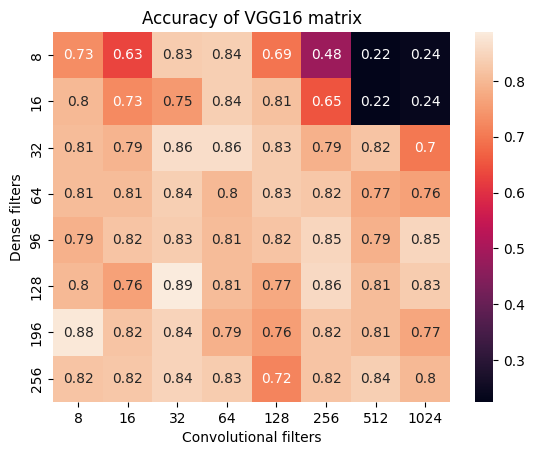

In [116]:
import seaborn as sn
import matplotlib.pyplot as plt

ax = plt.axes()
sn.heatmap(perchange_16, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=filters, 
           yticklabels=dense_sizes, ax = ax)
ax.set_title('Accuracy of VGG16 matrix')
plt.xlabel('Convolutional filters')
plt.ylabel('Dense filters')
plt.show()

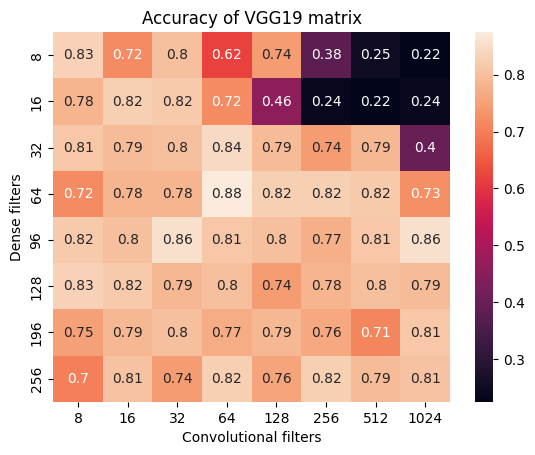

In [137]:
val_accs_19 = [i[4] for i in results_grid[64:]]
perchange_19 = ((np.asarray(val_accs_19)).reshape(8,8))

ax = plt.axes()
sn.heatmap(perchange_19, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=filters, 
           yticklabels=dense_sizes, ax = ax)
ax.set_title('Accuracy of VGG19 matrix')
plt.xlabel('Convolutional filters')
plt.ylabel('Dense filters')
plt.show()

## Restart with set dataset and VGG features

In [118]:
data_img, data_labels = create_sample(training_img, training_labels, 1000)

In [119]:
train_feat_vg16 = model16.predict(data_img)

32/32 [==============================] - 72s 2s/step


In [120]:
train_feat_vg19 = model19.predict(data_img)

32/32 [==============================] - 108s 3s/step


In [18]:
dropouts = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

In [124]:
def fitness_check(x):
    print(f"check {x}")
    drop = dropouts[round(x[0]-0.5)]
    dense_size = dense_sizes[round(x[1]-0.5)]
    if round(x[2]/2) >= 2.0:
        version = 19
        data = train_feat_vg19
    else:
        version = 16
        data = train_feat_vg16

    model = Sequential()
    model.add(Flatten(input_shape=(4, 4, 512)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    network = model.fit(data, data_labels, epochs=5, validation_split = 0.2)

    #test_loss, test_acc = model.evaluate(test_img, test_labels)

    history.append([version, drop, dense_size, network.history['accuracy'], network.history['val_accuracy'], network.history['loss'], network.history['val_loss']])
    print(network.history['accuracy'][-1])
    print(network.history['val_accuracy'][-1])

    return 1-network.history['val_accuracy'][-1]

In [125]:
w2 = wsa(5, fitness_check, 0, 8, dimension=3, iteration=10, ro0=0.005, eta=3.0)
best = w2.get_Gbest()
best_accuracy = fitness_check(np.array(best))

print(f'Best accuracy: {best_accuracy} for {best}')

check [4.34598572 5.72647872 0.69879209]
Epoch 1/5
25/25 [==============================] - 2s 30ms/step - loss: 1.0686 - accuracy: 0.5962 - val_loss: 0.6318 - val_accuracy: 0.7500
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 0.4640 - accuracy: 0.8363 - val_loss: 0.5013 - val_accuracy: 0.8200
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 0.3166 - accuracy: 0.9038 - val_loss: 0.5195 - val_accuracy: 0.8100
Epoch 4/5
25/25 [==============================] - 0s 18ms/step - loss: 0.2039 - accuracy: 0.9450 - val_loss: 0.4864 - val_accuracy: 0.8150
Epoch 5/5
25/25 [==============================] - 0s 17ms/step - loss: 0.1505 - accuracy: 0.9650 - val_loss: 0.5114 - val_accuracy: 0.7900
0.9649999737739563
0.7900000214576721
check [4.65542482 7.39225301 7.68559558]
Epoch 1/5
25/25 [==============================] - 2s 39ms/step - loss: 1.4183 - accuracy: 0.4888 - val_loss: 0.7503 - val_accuracy: 0.7250
Epoch 2/5
25/25 [=======================

In [127]:
pd.DataFrame(history[467:]).to_excel('output_new.xlsx', header=False, index=False)

In [128]:
results2 = []
best_val2 = 0
best_train2 = 0
best_data2 = []
for i in history[467:]:
    if i[4][-1] > best_val2:
        best_val2 = i[4][-1]
        best_train2 = i[3][-1]
        best_data2 = [i[0], i[1], i[2]]
    results2.append([i[0], i[1], i[2], i[3][-1], i[4][-1], i[5][-1], i[6][-1]])

print(f'Best accuracy: {best_val2}, {best_train2} for {best_data2}')

Best accuracy: 0.8399999737739563, 0.9599999785423279 for [16, 0.25, 128]


In [130]:
results_grid2 = []

In [131]:
for a in [16, 19]:
    for b in dense_sizes:
        for c in dropouts:
            if a == 19:
                data = train_feat_vg19
            else:
                data = train_feat_vg16

            model = Sequential()
            model.add(Flatten(input_shape=(4, 4, 512)))
            model.add(Dense(b, activation='relu'))
            model.add(Dropout(c))
            model.add(Dense(4, activation='softmax'))

            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


            network = model.fit(data, data_labels, epochs=5, validation_split = 0.2)

            results_grid2.append([a, c, b, network.history['accuracy'][-1], network.history['val_accuracy'][-1], network.history['loss'][-1], network.history['val_loss'][-1]])

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 1.2930 - accuracy: 0.3988 - val_loss: 1.1345 - val_accuracy: 0.5300
Epoch 2/5
25/25 [==============================] - 0s 12ms/step - loss: 0.9569 - accuracy: 0.6488 - val_loss: 0.8661 - val_accuracy: 0.6750
Epoch 3/5
25/25 [==============================] - 0s 11ms/step - loss: 0.6454 - accuracy: 0.8087 - val_loss: 0.7241 - val_accuracy: 0.7500
Epoch 4/5
25/25 [==============================] - 0s 11ms/step - loss: 0.4867 - accuracy: 0.8475 - val_loss: 0.6591 - val_accuracy: 0.7900
Epoch 5/5
25/25 [==============================] - 0s 11ms/step - loss: 0.3859 - accuracy: 0.8863 - val_loss: 0.6212 - val_accuracy: 0.7800
Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 1.3472 - accuracy: 0.3000 - val_loss: 1.2618 - val_accuracy: 0.2900
Epoch 2/5
25/25 [==============================] - 0s 11ms/step - loss: 1.2368 - accuracy: 0.3800 - val_loss: 1.1959 - val_accuracy: 0.4750
Epoch 3/5
25/25 [===

In [133]:
pd.DataFrame(results_grid2).to_excel('output_grid_new.xlsx', header=False, index=False)

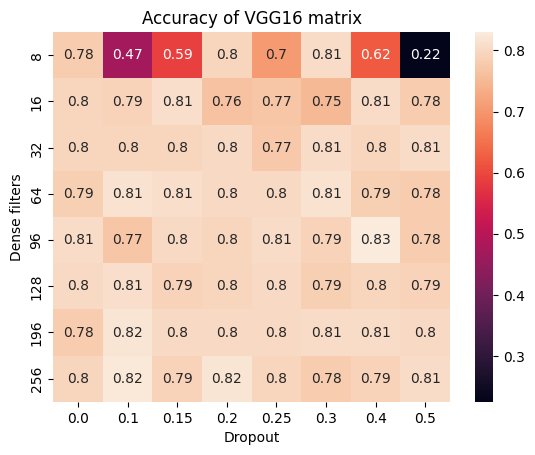

In [135]:
val_accs_16_2 = [i[4] for i in results_grid2[:64]]
perchange_16_2 = ((np.asarray(val_accs_16_2)).reshape(8,8))

ax = plt.axes()
sn.heatmap(perchange_16_2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=dropouts, 
           yticklabels=dense_sizes, ax = ax)
ax.set_title('Accuracy of VGG16 matrix')
plt.xlabel('Dropout')
plt.ylabel('Dense filters')
plt.show()

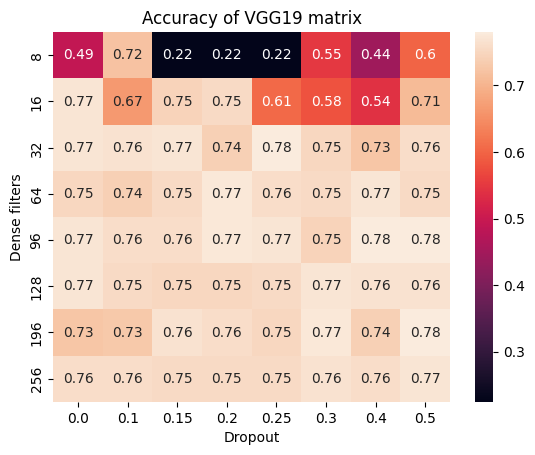

In [136]:
val_accs_19_2 = [i[4] for i in results_grid2[64:]]
perchange_19_2 = ((np.asarray(val_accs_19_2)).reshape(8,8))

ax = plt.axes()
sn.heatmap(perchange_19_2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=dropouts, 
           yticklabels=dense_sizes, ax = ax)
ax.set_title('Accuracy of VGG19 matrix')
plt.xlabel('Dropout')
plt.ylabel('Dense filters')
plt.show()

## ResNet-50

In [8]:
import torch

model_res50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\legion/.cache\torch\hub\pytorch_vision_v0.6.0


In [9]:
model_res50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
from keras.applications import ResNet50
#from keras.applications.resnet50 import preprocess_input

In [11]:
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [12]:
predictions_resnet50 = resnet_50.predict(training_img)

113/113 [==============================] - 83s 721ms/step


In [13]:
predictions_resnet50.shape

(3600, 5, 5, 2048)

In [24]:
resnet50_results = []

In [23]:
def fitness_resnet_check(x):
    print(f"check {x}")
    drop = dropouts[round(x[0]-0.5)]
    dense_size = dense_sizes[round(x[1]-0.5)]
    print(drop, dense_size)

    preds, labels = create_sample(predictions_resnet50, training_labels, 800)


    model = Sequential()
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    network = model.fit(preds, labels, epochs=5, batch_size=32, validation_split = 0.2)

    #test_loss, test_acc = model.evaluate(test_img, test_labels)

    resnet50_results.append([filter, dense_size, network.history['accuracy'][-1], network.history['val_accuracy'][-1], network.history['loss'][-1], network.history['val_loss'][-1]])
    print(network.history['accuracy'][-1])
    print(network.history['val_accuracy'][-1])

    return 1-network.history['val_accuracy'][-1]

In [25]:
w3 = wsa(5, fitness_resnet_check, 0, 8, dimension=2, iteration=10, ro0=0.005, eta=3.0)
best = w3.get_Gbest()
best_accuracy = fitness_resnet_check(np.array(best))

print(f'Best accuracy: {best_accuracy} for {best}')

check [1.06069216 7.71416386]
0.1 256
Epoch 1/5
20/20 [==============================] - 7s 289ms/step - loss: 2.6359 - accuracy: 0.3094 - val_loss: 1.2384 - val_accuracy: 0.3500
Epoch 2/5
20/20 [==============================] - 5s 253ms/step - loss: 1.1995 - accuracy: 0.4563 - val_loss: 1.1140 - val_accuracy: 0.4500
Epoch 3/5
20/20 [==============================] - 5s 257ms/step - loss: 1.1272 - accuracy: 0.4906 - val_loss: 1.1212 - val_accuracy: 0.4750
Epoch 4/5
20/20 [==============================] - 5s 262ms/step - loss: 1.0457 - accuracy: 0.5281 - val_loss: 1.1713 - val_accuracy: 0.4812
Epoch 5/5
20/20 [==============================] - 5s 264ms/step - loss: 1.0694 - accuracy: 0.5281 - val_loss: 1.0530 - val_accuracy: 0.5188
0.528124988079071
0.518750011920929
check [0.04752605 7.27981728]
0.0 256
Epoch 1/5
20/20 [==============================] - 7s 287ms/step - loss: 2.4505 - accuracy: 0.3281 - val_loss: 1.1978 - val_accuracy: 0.3875
Epoch 2/5
20/20 [=========================

In [28]:
pd.DataFrame(resnet50_results).to_excel('resnet50_results.xlsx', header=False, index=False)

In [37]:
print(len(w3.get_agents()[0]))

5


0.1 256


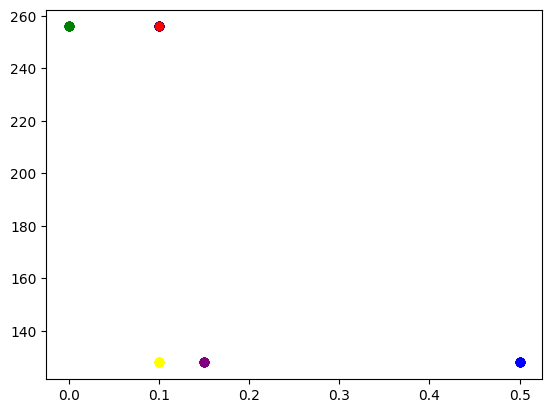

In [42]:
colors = ['navy', 'green', 'blue', 'purple', 'yellow', 'light green', 'yellow', 'dark green', 'dark blue', 'dark yellow', 'dark purple', 'light purple']
for x in w3.get_agents():
    for i in range(len(x)):
        plt.scatter(dropouts[round(x[i][0]-0.5)], dense_sizes[round(x[i][1]-0.5)], color=colors[i])
    #print(f'{x[0]} -> {ackley_function(np.array(x[0]))}')
best = w3.get_Gbest()
plt.scatter(dropouts[round(best[0]-0.5)], dense_sizes[round(best[1]-0.5)], color='red')
print(dropouts[round(best[0]-0.5)], dense_sizes[round(best[1]-0.5)])

In [43]:
results_resnet_grid = []

In [44]:
for b in dense_sizes:
    for c in dropouts:
        preds, labels = create_sample(predictions_resnet50, training_labels, 800)


        model = Sequential()
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(c))
        model.add(Dense(b, activation='relu'))
        model.add(Dropout(c))
        model.add(Dense(4, activation='softmax'))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


        network = model.fit(preds, labels, epochs=5, batch_size=32, validation_split = 0.2)

        results_resnet_grid.append([c, b, network.history['accuracy'][-1], network.history['val_accuracy'][-1], network.history['loss'][-1], network.history['val_loss'][-1]])

Epoch 1/5
20/20 [==============================] - 6s 267ms/step - loss: 1.5537 - accuracy: 0.2453 - val_loss: 1.3867 - val_accuracy: 0.2250
Epoch 2/5
20/20 [==============================] - 5s 242ms/step - loss: 1.3862 - accuracy: 0.2562 - val_loss: 1.3868 - val_accuracy: 0.2250
Epoch 3/5
20/20 [==============================] - 5s 240ms/step - loss: 1.3862 - accuracy: 0.2562 - val_loss: 1.3870 - val_accuracy: 0.2250
Epoch 4/5
20/20 [==============================] - 5s 250ms/step - loss: 1.3862 - accuracy: 0.2562 - val_loss: 1.3870 - val_accuracy: 0.2250
Epoch 5/5
20/20 [==============================] - 5s 236ms/step - loss: 1.3862 - accuracy: 0.2562 - val_loss: 1.3872 - val_accuracy: 0.2250
Epoch 1/5
20/20 [==============================] - 7s 292ms/step - loss: 1.4127 - accuracy: 0.2359 - val_loss: 1.3866 - val_accuracy: 0.2250
Epoch 2/5
20/20 [==============================] - 6s 281ms/step - loss: 1.3863 - accuracy: 0.2562 - val_loss: 1.3868 - val_accuracy: 0.2250
Epoch 3/5
20/

In [45]:
pd.DataFrame(results_resnet_grid).to_excel('resnet50_results_grid.xlsx', header=False, index=False)

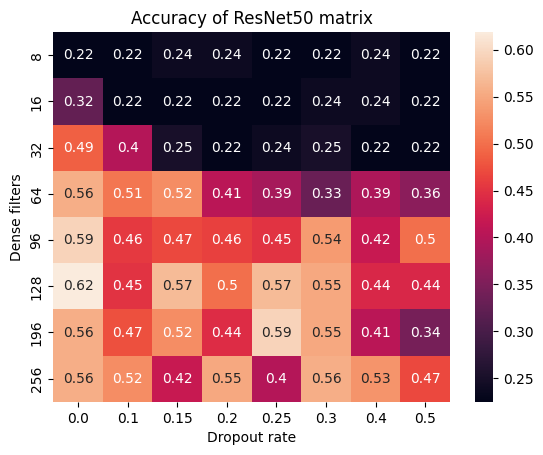

In [49]:
val_accs_res50 = [i[3] for i in results_resnet_grid]
perchange_res50 = ((np.asarray(val_accs_res50)).reshape(8,8))

ax = plt.axes()
sn.heatmap(perchange_res50, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=dropouts, 
           yticklabels=dense_sizes, ax = ax)
ax.set_title('Accuracy of ResNet50 matrix')
plt.xlabel('Dropout rate')
plt.ylabel('Dense filters')
plt.show()

## Saving best model

In [58]:
model = create_model(16, 32, 128)
model.summary()

Model: "sequential_682"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       multiple                  1792      
                                                                 
 block1_conv2 (Conv2D)       multiple                  36928     
                                                                 
 block1_pool (MaxPooling2D)  multiple                  0         
                                                                 
 block2_conv1 (Conv2D)       multiple                  73856     
                                                                 
 block2_conv2 (Conv2D)       multiple                  147584    
                                                                 
 block2_pool (MaxPooling2D)  multiple                  0         
                                                                 
 block3_conv1 (Conv2D)       multiple               

In [60]:
model.fit(training_img_shuffle, training_labels_shuffle, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
90/90 [==============================] - 128s 1s/step - loss: 0.7188 - accuracy: 0.7253 - val_loss: 0.5099 - val_accuracy: 0.8069
Epoch 2/10
90/90 [==============================] - 139s 2s/step - loss: 0.3360 - accuracy: 0.8861 - val_loss: 0.4760 - val_accuracy: 0.8389
Epoch 3/10
90/90 [==============================] - 143s 2s/step - loss: 0.2462 - accuracy: 0.9128 - val_loss: 0.5343 - val_accuracy: 0.8111
Epoch 4/10
90/90 [==============================] - 142s 2s/step - loss: 0.1682 - accuracy: 0.9448 - val_loss: 0.5204 - val_accuracy: 0.8347
Epoch 5/10
90/90 [==============================] - 138s 2s/step - loss: 0.1080 - accuracy: 0.9670 - val_loss: 0.4898 - val_accuracy: 0.8361
Epoch 6/10
90/90 [==============================] - 131s 1s/step - loss: 0.0542 - accuracy: 0.9878 - val_loss: 0.5833 - val_accuracy: 0.8361
Epoch 7/10
90/90 [==============================] - 125s 1s/step - loss: 0.0439 - accuracy: 0.9924 - val_loss: 0.5510 - val_accuracy: 0.8583
Epoch 8/10
90

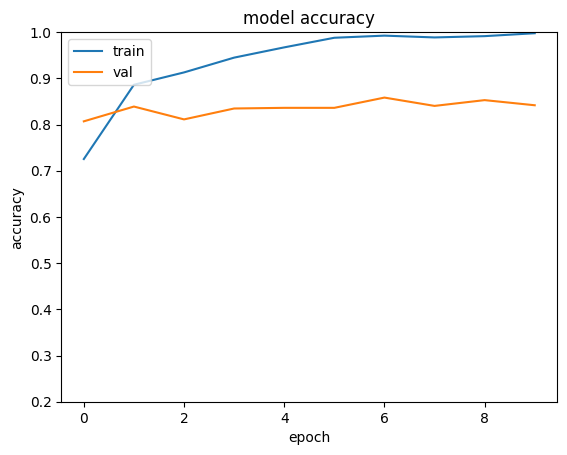

In [14]:
plt.plot([0.7253, 0.8861, 0.9128, 0.9448, 0.9670, 0.9878, 0.9924, 0.9885, 0.9913, 0.9976])
plt.plot([0.8069, 0.8389, 0.8111, 0.8347, 0.8361, 0.8361, 0.8583, 0.8403, 0.8528, 0.8417])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.2, 1)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
model.save('final_model.h5')

In [9]:
test_img_shuffle, test_labels_shuffle = shuffle(test_img, test_labels, random_state=21)

In [10]:
from keras.models import load_model

final_model = load_model('final_model.h5')

In [65]:
predictions = final_model.predict(test_img_shuffle)

25/25 [==============================] - 28s 1s/step


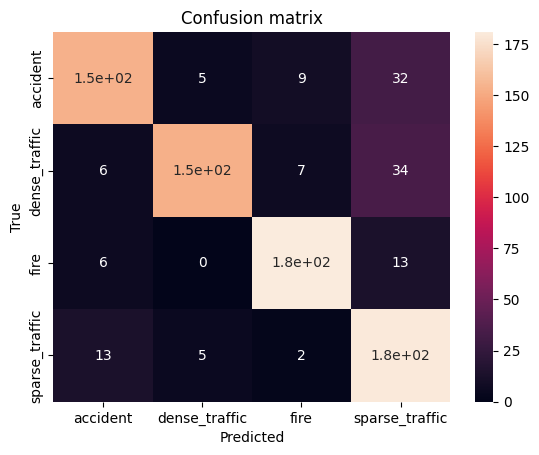

In [68]:
CM = confusion_matrix(test_labels_shuffle, np.argmax(predictions, axis = 1))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [71]:
from sklearn.metrics import accuracy_score
top_prediction = np.argmax(predictions, axis = 1)
accuracy = accuracy_score(test_labels_shuffle, top_prediction)
print(f'Accuracy: {accuracy}')

Accuracy: 0.835
